### Part2. Renderer Project

In [1]:
'''
Only import following libraries
'''
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import matplotlib.pyplot as plt
from math import atan, sin, cos  # only used for any extra math if needed
import numpy as np

In [2]:
'''
Define 3D Cube with conerss & edges with length of 2, centered at [0,0,0]
'''
vertices = np.array([
    [-1, -1, -1],   # 0
    [-1, -1, 1],    # 1
    [-1, 1, -1],    # 2
    [-1, 1, 1],     # 3
    [1, -1, -1],    # 4
    [1, -1, 1],     # 5
    [1, 1, -1],     # 6
    [1, 1, 1],      # 7
])

# A set of vertex pairs that are connected by edges
edges = [
    (0, 1), (0, 2), (0, 4),
    (1, 3), (1, 5),
    (2, 3), (2, 6),
    (3, 7),
    (4, 5), (4, 6),
    (5, 7),
    (6, 7)
]

In [3]:
'''
Two Given Visualizing Functions from assignment
'''
# Plot 3D points and connect them using the given edges.
def show_3d(points, edges, title="3D Plot"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Plot the vertices
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', s=50)
    # Draw the edges
    for edge in edges:
        p1 = points[edge[0]]
        p2 = points[edge[1]]
        xs = [p1[0], p2[0]]
        ys = [p1[1], p2[1]]
        zs = [p1[2], p2[2]]
        ax.plot(xs, ys, zs, 'b')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
# Plot 2D points and connect them with lines on a canvas (in pixels).
def show_2d(points, edges, canvas_size=250, title="2D Projection"):
    plt.figure(figsize=(6, 6))
    plt.scatter(points[:, 0], points[:, 1], c='r')
    for edge in edges:
        p1 = points[edge[0]]
        p2 = points[edge[1]]
        xs = [p1[0], p2[0]]
        ys = [p1[1], p2[1]]
        plt.plot(xs, ys, 'b')
    plt.title(title)
    plt.xlim(0, canvas_size)
    plt.ylim(0, canvas_size)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('x (pixels)')
    plt.ylabel('y (pixels)')
    plt.show()


Visualizing original cube in world coordinates


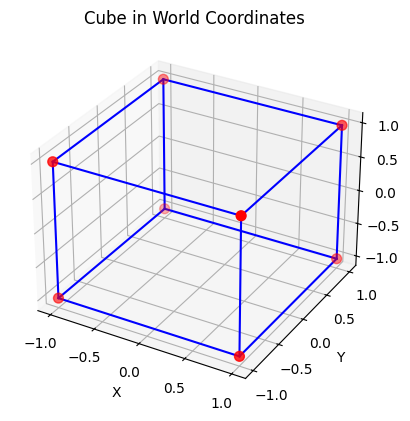

In [4]:
print("Visualizing original cube in world coordinates")
show_3d(vertices, edges, title="Cube in World Coordinates")

In [5]:
'''
Helper Function
- normalization
- np.eye -> expand_to_4x4
'''
# Vector Normalization
def normalize(elements):
    norm = sum(elem**2 for elem in elements) ** 0.5
    return np.array([elem / norm for elem in elements])

# Instead of using np.eye, we build the custom expand_to_4x4
def expand_to_4x4(m):
    m = [row.tolist() + [0] for row in m]
    m.append([0, 0, 0, 1])
    return np.array(m)

In [6]:
'''
Two Extrinsic camera functions: Transformation & Rotation
'''
# Create a 3x3 rotation matrix for a rotation by 'theta' radians around the unit axis 'unit'
def get_rotation_matrix(unit, theta):
    unit = np.array(unit, dtype=float)
    unit = unit / np.sqrt(np.sum(unit**2))
    ux, uy, uz = unit
    c = np.cos(theta)
    s = np.sin(theta)
    C = 1 - c
    R = np.array([
        [c + ux*ux*C,    ux*uy*C - uz*s, ux*uz*C + uy*s],
        [uy*ux*C + uz*s, c + uy*uy*C,    uy*uz*C - ux*s],
        [uz*ux*C - uy*s, uz*uy*C + ux*s, c + uz*uz*C   ]
    ])
    return R
    
# Create a 4x4 homogeneous translation matrix
def get_translation_matrix(t):
    return np.array([
        [1, 0, 0, -t[0]],
        [0, 1, 0, -t[1]],
        [0, 0, 1, -t[2]],
        [0, 0, 0, 1],
    ])

In [7]:
"""
Returns the 4x4 extrinsic matrix that transforms world coordinates into camera coordinates.
The rotation is applied in the order: first around x-axis, then y-axis, then z-axis.
Then transformation follows: X_cam = R * (X_world - position)
"""
def get_extrinsic_matrix(position, orientation):
    # Orientation angles: (angle_x, angle_y, angle_z) in radians.
    x, y, z = orientation
    rx = get_rotation_matrix([1, 0, 0], x)
    ry = get_rotation_matrix([0, 1, 0], y)
    rz = get_rotation_matrix([0, 0, 1], z)
    # Combined rotation
    r = rz @ ry @ rx

    # expand dimension for calculating
    r_4x4 = expand_to_4x4(r)
    
    # Create translation matrix to subtract camera position.
    t = get_translation_matrix(position)
    extrinsic = r_4x4 @ t
    return extrinsic

"""
Create the 3x4 intrinsic projection matrix.
f: focal length.
s: tuple (s_x, s_y) for the principal point.
The projection matrix K is:
    [ f   0   s_x   0 ]
    [ 0   f   s_y   0 ]
    [ 0   0    1    0 ]
"""
def get_intrinsic_matrix(f, s):
    s_x, s_y = s
    K = np.array([
        [f, 0, s_x, 0],
        [0, f, s_y, 0],
        [0, 0, 1,   0]
    ])
    return K

In [8]:
'''
Two Functions to convert the array of points 
- to homogenous coordinates
- homogenous coordinates back to Standard 2D/3D coordinates 
Followed by the calculation from 003_LightObjectImage pg.45
'''
# Convert (N x D) array of points to (N x (D+1)).
def to_homogenous(points):
    points = [row.tolist() + [1] for row in points]
    point = [1] * len(points[0])
    points.append(point)
    return np.array(points)

# For 3D points, divides by the 4th coordinate; for 2D, divides by the 3rd.
def from_homogenous(points):
    return points[:, :-1] / points[:, [-1]]

Visualizing cube in camera coordinates


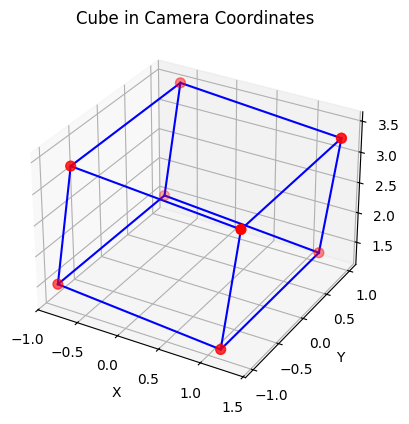

In [9]:
'''
Cube in Camera Coordinate Visualization
'''
# Define camera extrinsic parameters
camera_position = [0, 0, -2.4]
camera_orientation = [0, 0.11, 0]  # in radians

# Compute the extrinsic matrix
extrinsic = get_extrinsic_matrix(camera_position, camera_orientation)

# Convert cube vertices to homogeneous coordinates, transform them, then convert back.
cube_hom = to_homogenous(vertices) # Shape: (8, 4)
cube_cam_hom = (extrinsic @ cube_hom.T).T # Transform to camera coordinates
cube_cam = from_homogenous(cube_cam_hom) # Back to 3D (Cartesian)

# Show the cube in camera coordinates
print("Visualizing cube in camera coordinates")
show_3d(cube_cam, edges, title="Cube in Camera Coordinates")

Visualizing projected cube on 2D Space


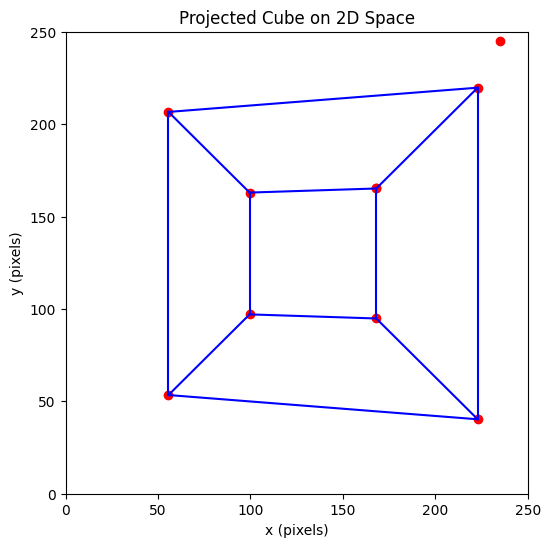

In [10]:
'''
Project cube to 2D space
'''
# Define intrinsic parameters
f = 0.46
s = (0.48, 0.52)
intrinsic = get_intrinsic_matrix(f, s)

# Project the cube (in camera coordinates) onto the image plane.
cube_cam_hom = to_homogenous(cube_cam)  
projected_hom = (intrinsic @ cube_cam_hom.T).T  
projected_2d = from_homogenous(projected_hom)

# Multiply by the canvas size (250x250 pixels) to get pixel coordinates.
canvas_size = 250
projected_pixels = projected_2d * canvas_size

# Plot the final 2D projection using the helper function.
print("Visualizing projected cube on 2D Space")
show_2d(projected_pixels, edges, canvas_size=canvas_size, title="Projected Cube on 2D Space")

### Bonus (20 points): 
#### Insert code that rotates the camera around the cube from left to right and shows the resulting views [you can do an animation, or the individual views, both are fine!]


In [11]:
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
from IPython.display import HTML
# Switch to notebook mode for animations
%matplotlib notebook
canvas_size = (250, 250)  # (width, height) in pixels

In [12]:
"""
Create camera rotation animation
"""
def compute_projection(camera_angle):
    d = 3.0  # fixed distance from the cube
    
    # Define camera position 
    camera_position = [d * sin(camera_angle), 0, -d * cos(camera_angle)]
    
    # Compute camera_center so that the camera faces the cube center:
    camera_center = np.arctan2(camera_position[0], camera_position[2])
    camera_orientation = [0, camera_center, 0]  
    
    # Get extrinsic matrix 
    extrinsic = get_extrinsic_matrix(camera_position, camera_orientation)
    
    # Transform cube vertices into camera coordinates
    cube_hom = to_homogenous(vertices)
    cube_cam_hom = (extrinsic @ cube_hom.T).T
    cube_cam = from_homogenous(cube_cam_hom)
    
    # Project the camera coordinates using the intrinsic matrix
    cube_cam_hom2 = to_homogenous(cube_cam)  
    projected_hom = (intrinsic @ cube_cam_hom2.T).T  
    projected_2d = from_homogenous(projected_hom)
    
    # Scale to canvas pixel coordinates
    projected_pixels = projected_2d * np.array([canvas_size[0], canvas_size[1]])
    return projected_pixels

In [13]:
'''
Set ups for the Cube animation
'''
# Initialize the figure and axis for the animation
fig, ax = plt.subplots()
ax.set_xlim(0, canvas_size[0])
ax.set_ylim(0, canvas_size[1])
ax.set_aspect('equal', adjustable='box')

# Pre_create line objects for each edge
lines = []
for _ in edges:
   line, = ax.plot([], [], 'b')
   lines.append(line)

# Title to display the current camera angle (in degrees)
title_text = ax.text(0.5, 1.05, "", transform=ax.transAxes, ha="center", fontsize=12)

# Initialization function for the animation
def init():
   # Clear all lines 
   for line in lines:
       line.set_data([], [])
   # Clear the title text
   title_text.set_text("")
   # Return all objects that will be updated in the animation
   return lines + [title_text]

# Animation function called for each frame
def animate(i):
   # For 30 frames, let the camera angle vary from -0.5 to 0.5 radians around -30° ~ 30°
   camera_angle = -0.5 + i * (1.0 / 29)
   # Compute the projected cube vertices for this camera angle
   proj = compute_projection(camera_angle)
   
   # Update each edge 
   for j, edge in enumerate(edges):
       p1 = proj[edge[0]]
       p2 = proj[edge[1]]
       lines[j].set_data([p1[0], p2[0]], [p1[1], p2[1]])
   
   # Update the title text with the current camera angle in degrees
   title_text.set_text(f"Camera angle: {np.degrees(camera_angle):.1f}°")
   
   # Return all objects that were updated
   return lines + [title_text]

<IPython.core.display.Javascript object>

In [14]:
'''
Start Animation
'''
ani = animation.FuncAnimation(fig, animate, frames=30, init_func=init,interval=300, blit=True)
HTML(ani.to_jshtml())